In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

from pmdarima.arima import auto_arima
from pmdarima.arima import ARIMA

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [2]:

# You can use the parse_dates and dayfirst arguments of pd.read_csv, see: the docs for read_csv()

# df = pd.read_csv('myfile.csv', parse_dates=['Date'], dayfirst=True)

In [102]:
df = pd.read_csv(r"Datos Completos\Octubre-Abril.csv", sep= "\t", parse_dates=["PoC AB12"], dayfirst=True)
df.columns = ["Date","Pax"]
df = df.iloc[4:,:].reset_index(False)
df = df.drop("index", axis=1)
df

,Date,Pax
0,01-04-2024 00:01:38,0
1,01-04-2024 00:02:34,0
2,01-04-2024 00:03:39,0
3,01-04-2024 00:04:34,0
4,01-04-2024 00:05:35,0
...,...,...
210481,31-10-2023 15:09:39,0
210482,31-10-2023 15:10:39,0
210483,31-10-2023 15:11:39,0
210484,31-10-2023 15:12:39,0


In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210486 entries, 0 to 210485
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Date    210486 non-null  object
 1   Pax     210486 non-null  object
dtypes: object(2)
memory usage: 3.2+ MB


In [104]:
df.describe()

,Date,Pax
count,210486,210486
unique,210486,7
top,01-04-2024 00:01:38,0
freq,1,182727


In [107]:
df["Date"].dtype

dtype('O')

In [108]:
df["Date"] = pd.to_datetime(df["Date"],  format="%d-%m-%Y %H:%M:%S")
df["Pax"] = pd.to_numeric(df["Pax"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210486 entries, 0 to 210485
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Date    210486 non-null  datetime64[ns]
 1   Pax     210486 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.2 MB


In [109]:
df["month"] = df["Date"].dt.month
df["month"] = df["Date"].dt.month
df["Hour"] = df["Date"].dt.hour
df["Day"] = df["Date"].dt.day
df["Year"] = df["Date"].dt.year
df
# df["Fecha"] = pd.to_datetime(df["Fecha"],  format="%d-%m-%Y %H:%M:%S")




,Date,Pax,month,Hour,Day,Year
0,2024-04-01 00:01:38,0,4,0,1,2024
1,2024-04-01 00:02:34,0,4,0,1,2024
2,2024-04-01 00:03:39,0,4,0,1,2024
3,2024-04-01 00:04:34,0,4,0,1,2024
4,2024-04-01 00:05:35,0,4,0,1,2024
...,...,...,...,...,...,...
210481,2023-10-31 15:09:39,0,10,15,31,2023
210482,2023-10-31 15:10:39,0,10,15,31,2023
210483,2023-10-31 15:11:39,0,10,15,31,2023
210484,2023-10-31 15:12:39,0,10,15,31,2023


In [110]:
""" al parecer los meses de Marzo y Octubre no tienen registrado el día 1"""
df[df["Day"]==1].loc[:,"month"].unique()

array([ 4,  2,  1, 12, 11])

In [94]:
# dff = df.drop("Fecha",axis = 1)
# dff


In [111]:
df = df.groupby(["Hour","month","Day","Year"])[["Pax"]].max().reset_index()
df

,Hour,month,Day,Year,Pax
0,0,1,2,2024,0
1,0,1,3,2024,0
2,0,1,4,2024,0
3,0,1,5,2024,0
4,0,1,6,2024,0
...,...,...,...,...,...
3537,23,12,26,2023,0
3538,23,12,27,2023,0
3539,23,12,28,2023,0
3540,23,12,29,2023,0


In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3542 entries, 0 to 3541
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Hour    3542 non-null   int32
 1   month   3542 non-null   int32
 2   Day     3542 non-null   int32
 3   Year    3542 non-null   int32
 4   Pax     3542 non-null   int64
dtypes: int32(4), int64(1)
memory usage: 83.1 KB


In [113]:
""" eliminamos cualquier detección fuerea de las horas laborales de la oficina"""

df.loc[df['Hour'] == 0, 'Pax'] = 0
df.loc[df['Hour'] == 1, 'Pax'] = 0
df.loc[df['Hour'] == 2, 'Pax'] = 0
df.loc[df['Hour'] == 3, 'Pax'] = 0
df.loc[df['Hour'] == 4, 'Pax'] = 0
df.loc[df['Hour'] == 5, 'Pax'] = 0
df.loc[df['Hour'] == 6, 'Pax'] = 0
df.loc[df['Hour'] == 20, 'Pax'] = 0
df.loc[df['Hour'] == 21, 'Pax'] = 0
df.loc[df['Hour'] == 22, 'Pax'] = 0
df.loc[df['Hour'] == 23, 'Pax'] = 0

df


,Hour,month,Day,Year,Pax
0,0,1,2,2024,0
1,0,1,3,2024,0
2,0,1,4,2024,0
3,0,1,5,2024,0
4,0,1,6,2024,0
...,...,...,...,...,...
3537,23,12,26,2023,0
3538,23,12,27,2023,0
3539,23,12,28,2023,0
3540,23,12,29,2023,0


In [141]:
""" separación de datos por meses"""

df4 = df.loc[df.loc[:,"month"]==4]
df3 = df.loc[df.loc[:,"month"]==3]
df2 = df.loc[df.loc[:,"month"]==2]
df1 = df.loc[df.loc[:,"month"]==1]
df12 = df.loc[df.loc[:,"month"]==12]
df11 = df.loc[df.loc[:,"month"]==11]
df10 = df.loc[df.loc[:,"month"]==10]


In [158]:
df41 = df4.drop("Pax", axis=1)
df31 = df3.drop("Pax", axis=1)
df21 = df2.drop("Pax", axis=1)
df01 = df1.drop("Pax", axis=1)
df121 = df12.drop("Pax", axis=1)
df111 = df11.drop("Pax", axis=1)
df101 = df10.drop("Pax", axis=1)


In [166]:
df41["Year","month","Day"] = pd.to_datetime(df41)
df31["Year","month","Day"] = pd.to_datetime(df31)
df21["Year","month","Day"] = pd.to_datetime(df21)
df01["Year","month","Day"] = pd.to_datetime(df01)
df121["Year","month","Day"] = pd.to_datetime(df121)
df111["Year","month","Day"] = pd.to_datetime(df111)
df101["Year","month","Day"] = pd.to_datetime(df101)

In [168]:
df4["Fecha"] = df41.iloc[:,4]
df3["Fecha"] = df31.iloc[:,4]
df2["Fecha"] = df21.iloc[:,4]
df1["Fecha"] = df01.iloc[:,4]
df12["Fecha"] = df121.iloc[:,4]
df11["Fecha"] = df111.iloc[:,4]
df10["Fecha"] = df101.iloc[:,4]

In [170]:
df11


,Hour,month,Day,Year,Pax,Fecha
89,0,11,2,2023,0,2023-11-02 00:00:00
90,0,11,3,2023,0,2023-11-03 00:00:00
91,0,11,4,2023,0,2023-11-04 00:00:00
92,0,11,5,2023,0,2023-11-05 00:00:00
93,0,11,6,2023,0,2023-11-06 00:00:00
...,...,...,...,...,...,...
3507,23,11,25,2023,0,2023-11-25 23:00:00
3508,23,11,26,2023,0,2023-11-26 23:00:00
3509,23,11,27,2023,0,2023-11-27 23:00:00
3510,23,11,28,2023,0,2023-11-28 23:00:00


In [171]:
df4["Pax"] = df["Pax"]*10

In [172]:
df4.loc[:,"Pax"]

50      0
51      0
52      0
53      0
54      0
       ..
3469    0
3470    0
3471    0
3472    0
3473    0
Name: Pax, Length: 720, dtype: int64

<Axes: xlabel='Fecha'>

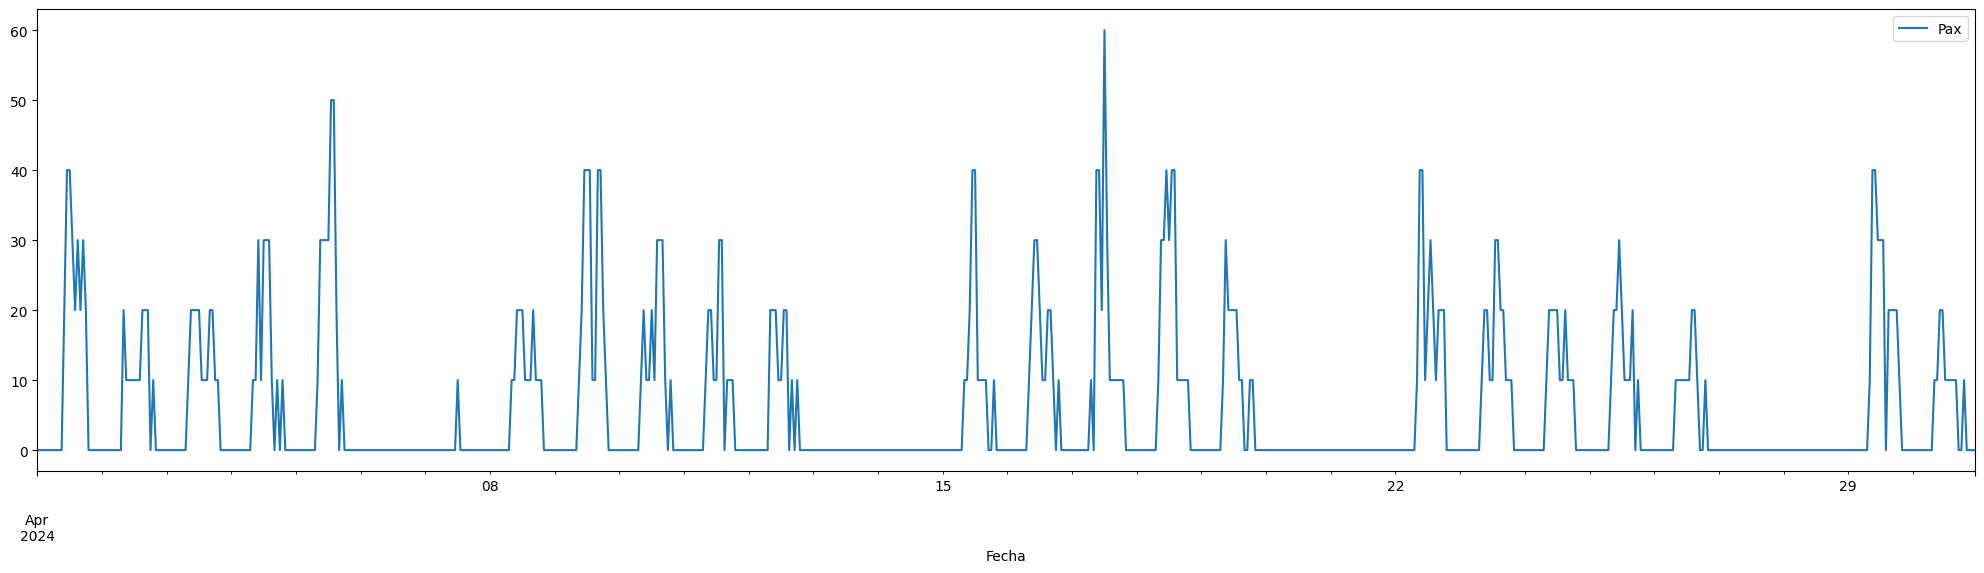

In [173]:
""" gráfico mostrando nº personas (multiplicado por 10 para mejor visualización) por cada dia de la semana (en horas)"""
df4.groupby("Fecha")[["Pax"]].max().plot(figsize=(25,6))

<Axes: xlabel='Fecha'>

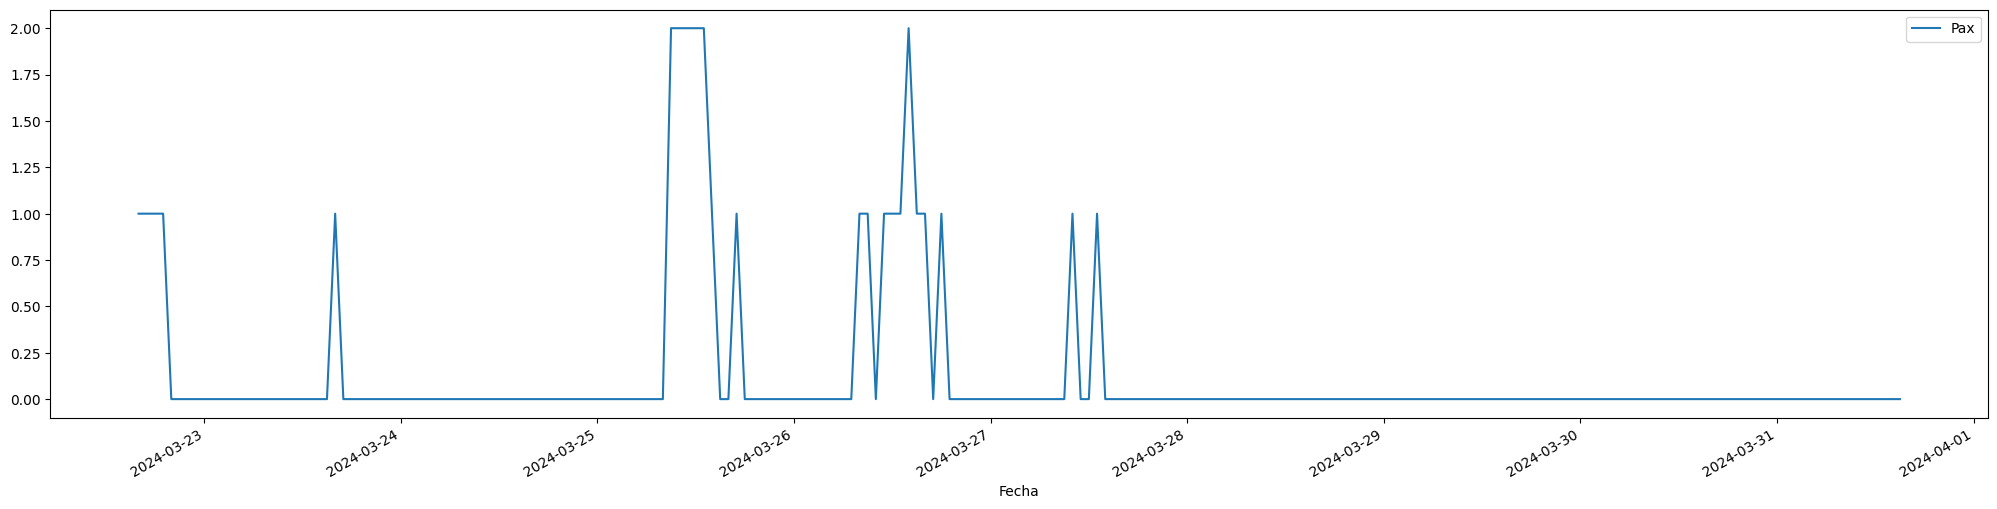

In [175]:
df3.groupby("Fecha")[["Pax"]].max().plot(figsize=(25,6))

<Axes: xlabel='Fecha'>

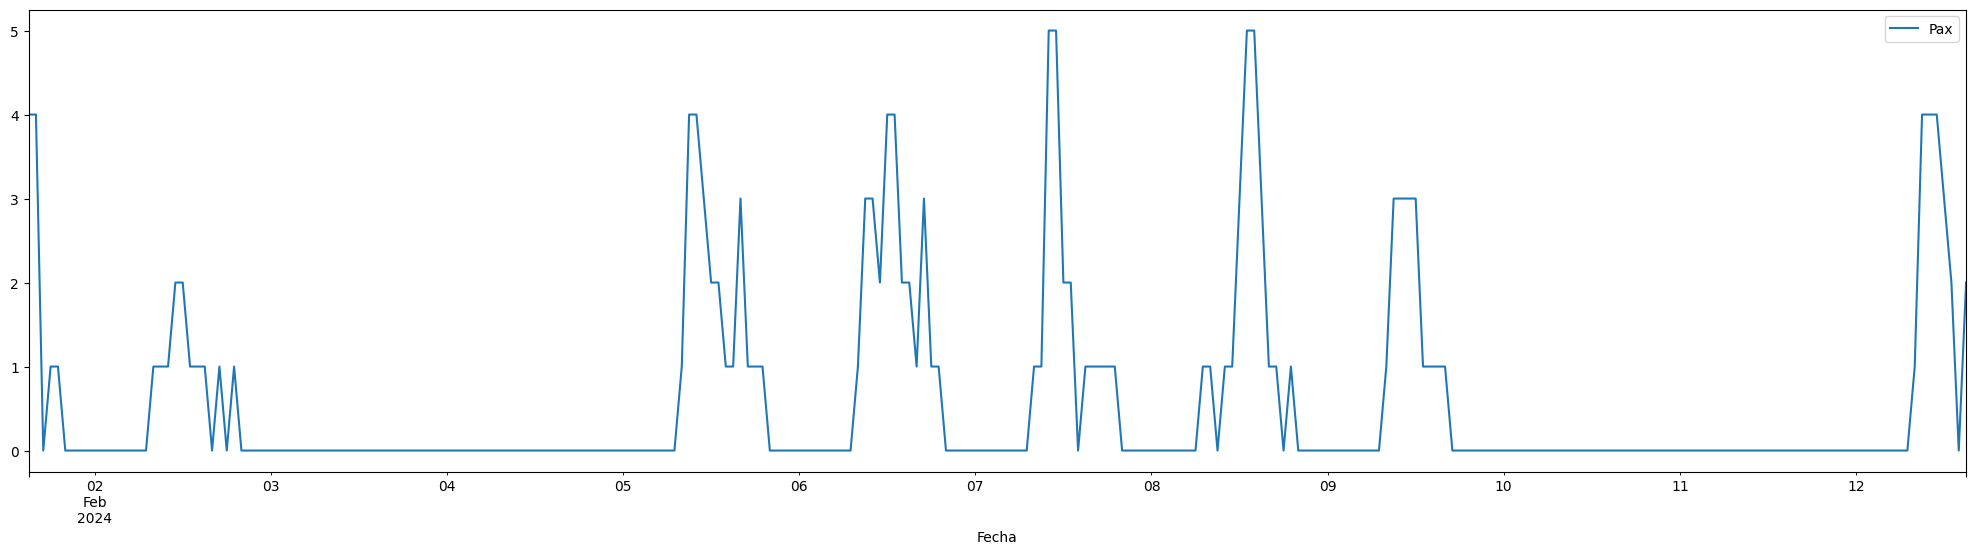

In [176]:
df2.groupby("Fecha")[["Pax"]].max().plot(figsize=(25,6))

<Axes: xlabel='Fecha'>

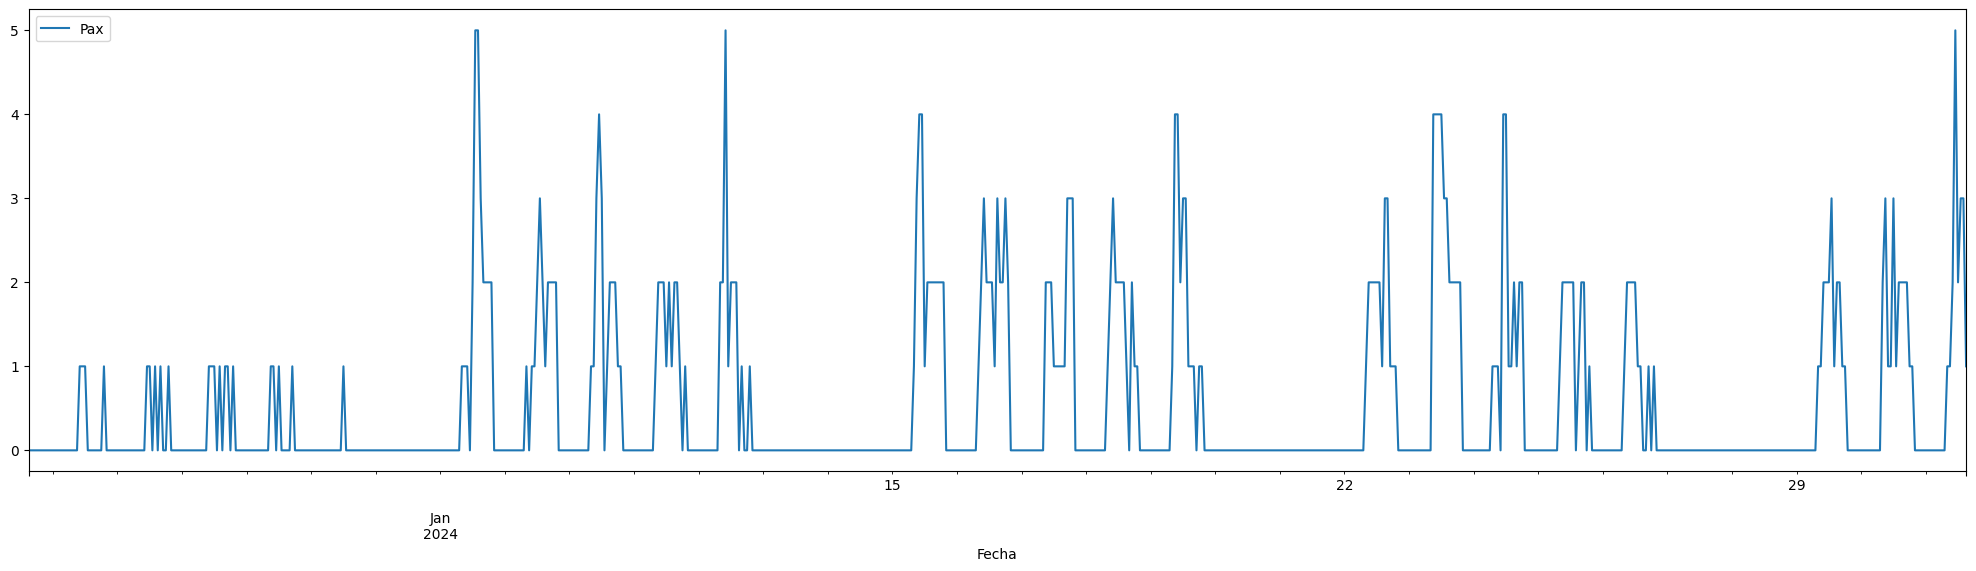

In [177]:
df1.groupby("Fecha")[["Pax"]].max().plot(figsize=(25,6))

<Axes: xlabel='Fecha'>

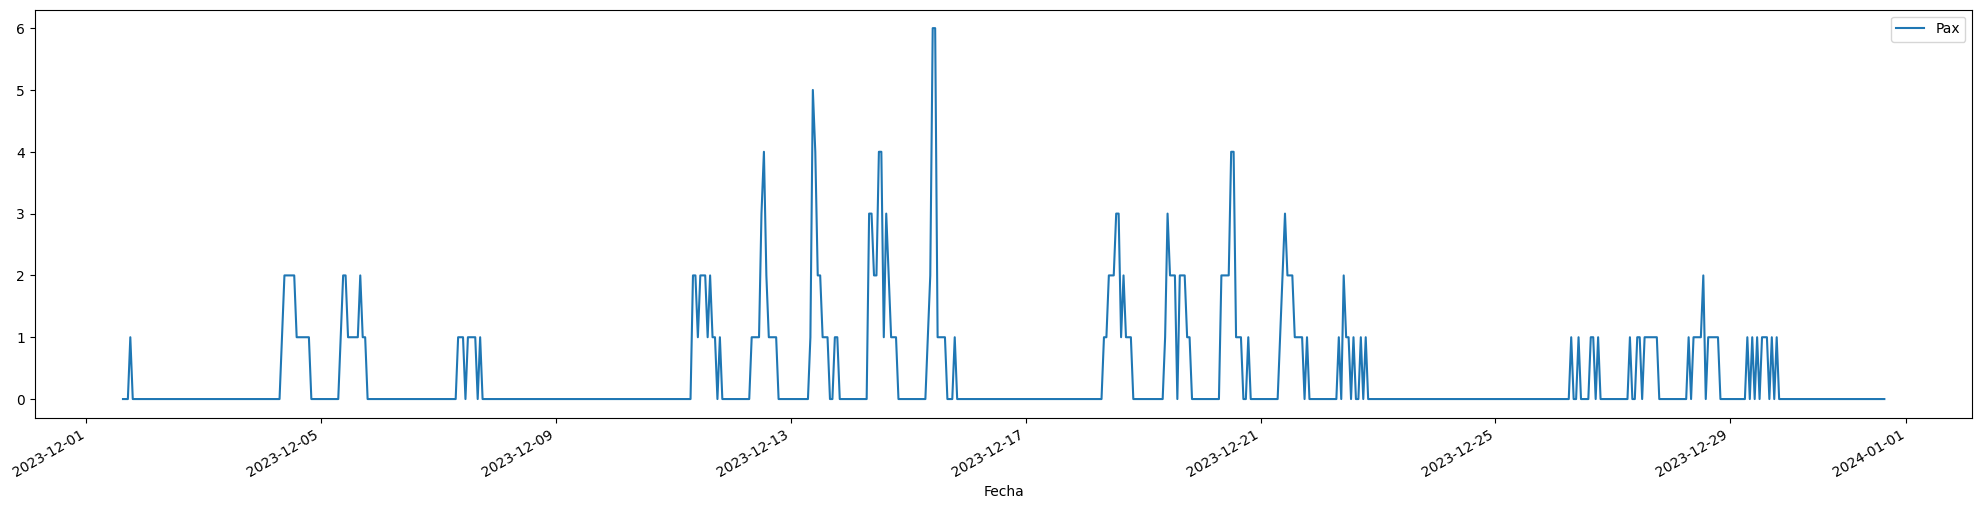

In [178]:
df12.groupby("Fecha")[["Pax"]].max().plot(figsize=(25,6))

<Axes: xlabel='Fecha'>

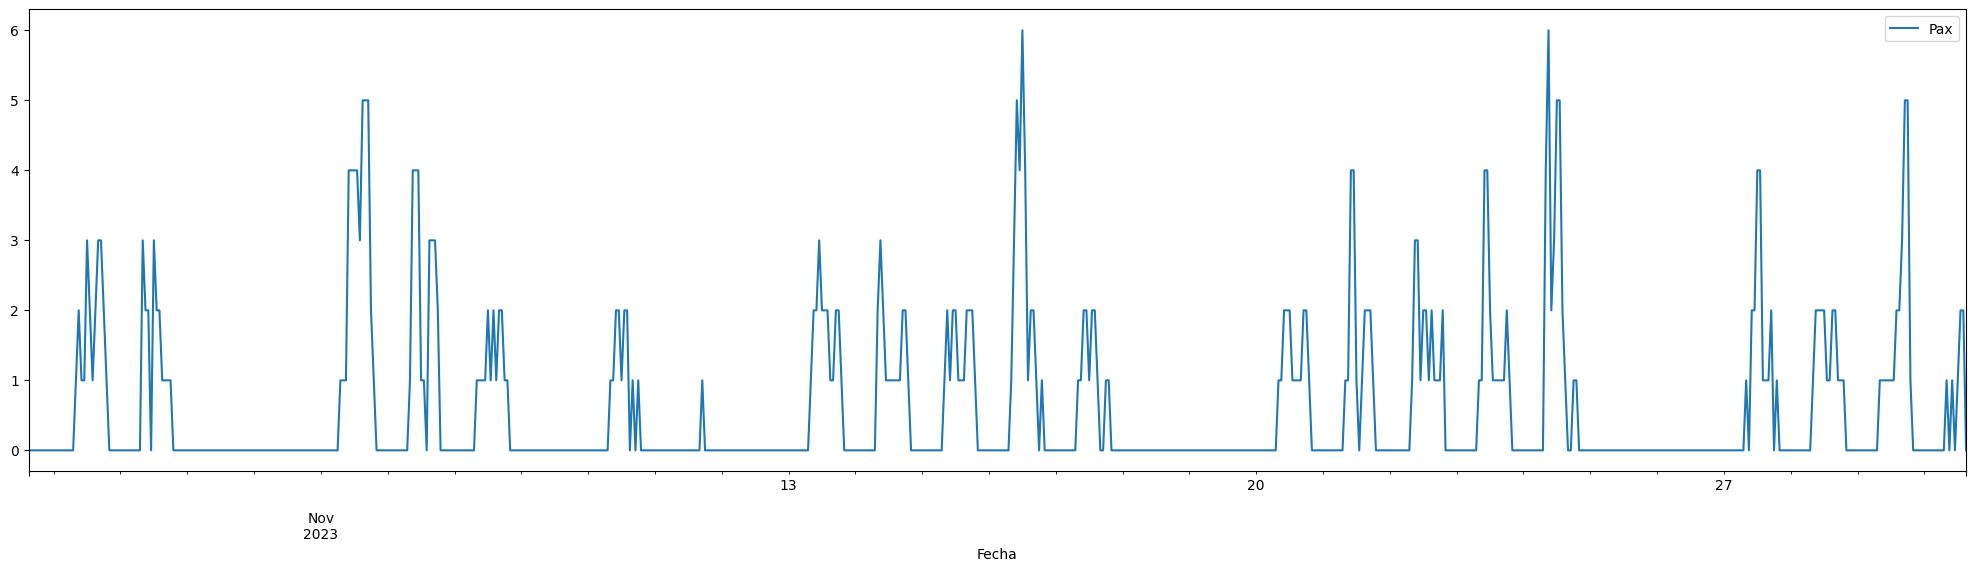

In [179]:
df11.groupby("Fecha")[["Pax"]].max().plot(figsize=(25,6))

<Axes: xlabel='Fecha'>

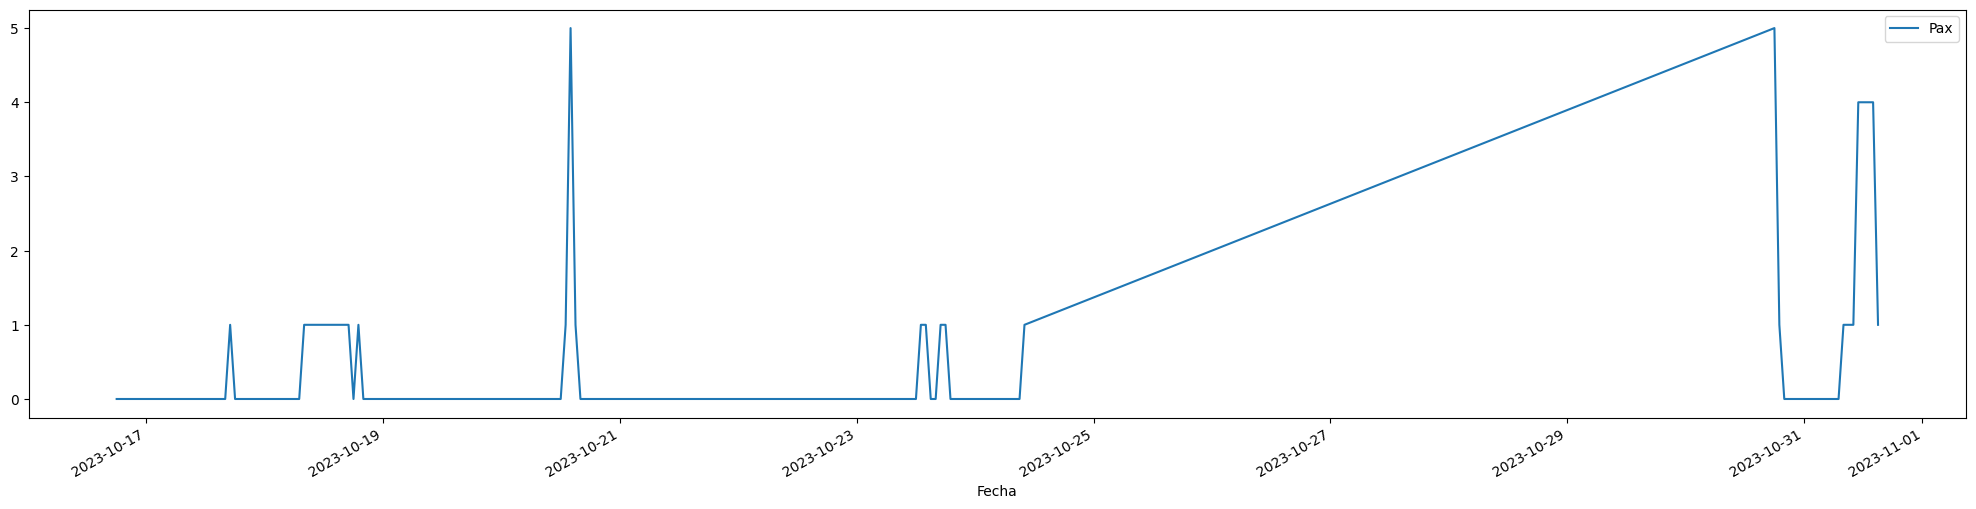

In [180]:
df10.groupby("Fecha")[["Pax"]].max().plot(figsize=(25,6))

In [174]:
""" muestra de personas por hora detectadas en 1 dia (1 de Abril)"""
df41 = df4.loc[df4.loc[:,"Day"]==1]
df41.groupby("Hour")[["Pax"]].max().reset_index()
# df41

,Hour,Pax
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,8,0
9,9,0


In [ ]:
df41.groupby("Hour")[["Pax"]].max().reset_index(drop = True).plot(figsize=(15,6))

In [ ]:
plot_acf(df41.groupby("Hour")[["Pax"]].max().reset_index(drop = True))

In [ ]:
df4

In [ ]:
df41.groupby("Hour")[["Nº Personas"]].max().reset_index(drop = True).plot(figsize=(15,6))

In [ ]:
df41_21 = df41.loc[df41.loc[:,"Hour"]==21]
df41_21.loc[df41_21.loc[:,"Nº Personas"]!=0]

In [ ]:
df41_20 = df41.loc[df41.loc[:,"Hour"]==20]
df41_20.loc[df41_20.loc[:,"Nº Personas"]!=0]

In [ ]:
# df41_21.loc[df41_21.loc[1340:1350, "Nº Personas"].index]

In [ ]:
# df41_20.loc[df41_20.loc[1260:1270, "Nº Personas"].index]

In [ ]:
df42 =  df4.loc[df4.loc[:,"Day_month"]==2]
df42.groupby("Hour")[["Nº Personas"]].max().reset_index()
df42_0 = df42.loc[df42.loc[:,"Hour"]==0]
df42_0.loc[df42_0.loc[:,"Nº Personas"]!=0]


In [ ]:
df42_0 = df42.loc[df42.loc[:,"Hour"]==1]
df42_0.loc[df42_0.loc[:,"Nº Personas"]!=0]

In [ ]:
df44 =  df4.loc[df4.loc[:,"Day_month"]==1]
df44.groupby("Hour")[["Nº Personas"]].max().reset_index()
df44_0 = df44.loc[df44.loc[:,"Hour"]==20]
df44_0.loc[df44_0.loc[:,"Nº Personas"]!=0]

In [ ]:
abril = []
for i in np.arange(1,31):
    
    abril.append(df4.loc[df4.loc[:,"Day_month"]==i].groupby("Hour")[["Nº Personas"]].max().reset_index())


In [ ]:
abril

In [ ]:
len(abril)

In [ ]:
for idx,i  in enumerate(abril):
    print(f"Dia {idx+1}",abril[idx])

In [ ]:
df4.loc[:,]

In [ ]:
sns.pairplot(df4)


In [ ]:
plt.plot(df3["Day"], df3["Nº Personas"])


In [ ]:
plt.plot(df2["Day"], df2["Nº Personas"])


In [ ]:
plt.plot(df1["Day"], df1["Nº Personas"])


In [ ]:
plt.plot(df12["Day"], df12["Nº Personas"])


In [ ]:
plt.plot(df11["Day"], df11["Nº Personas"])


In [ ]:
plt.plot(df10["Day"], df10["Nº Personas"])

In [ ]:
""" Nº de personas máximas por hora durante el mes"""
df4p = df4.loc[df4.loc[:,"Nº Personas"]!=0].groupby("Hour")[["Nº Personas"]].max().reset_index()
df3p = df3.loc[df3.loc[:,"Nº Personas"]!=0].groupby("Hour")[["Nº Personas"]].max().reset_index()
df2p = df2.loc[df2.loc[:,"Nº Personas"]!=0].groupby("Hour")[["Nº Personas"]].max().reset_index()
df1p = df1.loc[df1.loc[:,"Nº Personas"]!=0].groupby("Hour")[["Nº Personas"]].max().reset_index()
df12p = df12.loc[df12.loc[:,"Nº Personas"]!=0].groupby("Hour")[["Nº Personas"]].max().reset_index()
df11p = df11.loc[df11.loc[:,"Nº Personas"]!=0].groupby("Hour")[["Nº Personas"]].max().reset_index()
df10p = df10.loc[df10.loc[:,"Nº Personas"]!=0].groupby("Hour")[["Nº Personas"]].max().reset_index()


In [ ]:
df4p

In [ ]:

df = df4p

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=df4p["Hour"], y=df4p["Nº Personas"], data=df, palette='viridis')

# Añadir títulos y etiquetas
plt.xlabel('Hora')
plt.ylabel('Personas')
plt.title('Personas/Hora Abril')

# Mostrar la gráfica
plt.show()


In [ ]:
DFS = [df4,df3,df2,df1,df12,df11,df10]

In [ ]:
# for idx, i in enumerate(DFS[0]):
#     df = DFS[idx]

# # Crear la gráfica de barras
#     plt.figure(figsize=(10, 6))
#     sns.barplot(x=df["Hour"], y=df["Nº Personas"], data=df, palette='viridis')

#     # Añadir títulos y etiquetas
#     plt.xlabel('Hora')
#     plt.ylabel('Personas')
#     plt.title('Personas/Hora')

#     # Mostrar la gráfica
#     plt.show()

In [ ]:
df = df3p

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=df3p["Hour"], y=df3p["Nº Personas"], data=df, palette='viridis')

# Añadir títulos y etiquetas
plt.xlabel('Hora')
plt.ylabel('Personas')
plt.title('Personas/Hora Marzo')

# Mostrar la gráfica
plt.show()

In [ ]:

df = df2p

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=df2p["Hour"], y=df2p["Nº Personas"], data=df, palette='viridis')

# Añadir títulos y etiquetas
plt.xlabel('Hora')
plt.ylabel('Personas')
plt.title('Personas/Hora Febrero')

# Mostrar la gráfica
plt.show()


In [ ]:

df = df1p

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=df1p["Hour"], y=df1p["Nº Personas"], data=df, palette='viridis')

# Añadir títulos y etiquetas
plt.xlabel('Hora')
plt.ylabel('Personas')
plt.title('Personas/Hora Enero')

# Mostrar la gráfica
plt.show()


In [ ]:

df = df12p

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=df12p["Hour"], y=df12p["Nº Personas"], data=df, palette='viridis')

# Añadir títulos y etiquetas
plt.xlabel('Hora')
plt.ylabel('Personas')
plt.title('Personas/Hora Diciembre')

# Mostrar la gráfica
plt.show()


In [ ]:

df = df11p

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=df11p["Hour"], y=df11p["Nº Personas"], data=df, palette='viridis')

# Añadir títulos y etiquetas
plt.xlabel('Hora')
plt.ylabel('Personas')
plt.title('Personas/Hora Noviembre')

# Mostrar la gráfica
plt.show()


In [ ]:

df = df10p

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=df10p["Hour"], y=df10p["Nº Personas"], data=df, palette='viridis')

# Añadir títulos y etiquetas
plt.xlabel('Hora')
plt.ylabel('Personas')
plt.title('Personas/Hora Octubre')

# Mostrar la gráfica
plt.show()


In [ ]:
df4_m = df4.loc[df4.loc[:,"Day"]=="Monday"].groupby("Hour")[["Nº Personas"]].max().reset_index()
df4_m

In [ ]:

df = df4_m

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=df4_m["Hour"], y=df4_m["Nº Personas"], data=df, palette='viridis')

# Añadir títulos y etiquetas
plt.xlabel('Hora')
plt.ylabel('Personas')
plt.title('Personas max/Hora Abril Lunes')

# Mostrar la gráfica
plt.show()